# Notebook 4 - Inverse design: molecules on specification

By Vincent Blay, December 2021

In this notebook we demonstrate two approaches to the generation of new molecules with a desired property specification by leveraging MACAW embeddings. 

In the first approach we generate a single large library throughout the MACAW embedding space and then retrieve promising molecules using the `hit_finder` functions.

In the second approach we generate a series of small libraries using an evolutionary strategy using the `library_evolver` function.

In both cases, the user is returned a list of promising SMILES molecules and their predicted property values.

In [1]:
import numpy as np
import pandas as pd

#Needed to show molecules
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole 

from sklearn_rvm import EMRVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import sys
import os
from rdkit import Chem
from rdkit.Chem import RDConfig

sys.path.append('../')
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

import macaw
print(macaw.__version__)

from macaw import *

1.0.1


In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
np.random.seed(123)

In this example we will use the RON dataset, so let us load it

In [4]:
df = pd.read_csv('./data/data_RON.csv')
smiles = df.Smiles
Y = df.RON

In [5]:
len(smiles)

194

In this case we are generating new molecules, so we are working with the whole dataset.

Let's generate the MACAM embedder and the RON model trained on the whole data set:

In [6]:
mcw = MACAW_optimus(smiles, Y, verbose=True, n_components=15, n_landmarks=100, random_state=57)
X = mcw.transform(smiles)

Problem type identified as regression
morgan2 & tanimoto: 0.368
morgan3 & tanimoto: 0.374
rdk5 & tanimoto: 0.472
rdk7 & tanimoto: 0.505
featmorgan2 & tanimoto: 0.395
featmorgan3 & tanimoto: 0.398
maccs & tanimoto: 0.532
avalon & tanimoto: 0.302
atompairs & tanimoto: 0.565
torsion & tanimoto: 0.331
pattern & tanimoto: 0.492
secfp6 & tanimoto: 0.328
layered & tanimoto: 0.573
layered & tanimoto: 0.573
layered & cosine: 0.589
layered & dice: 0.590
layered & sokal: 0.563
layered & kulczynski: 0.605
layered & mcconnaughey: 0.605
layered & braun-blanquet: 0.562
layered & rogot-goldberg: 0.591
layered & asymmetric: 0.468
layered & manhattan: 0.530
layered & blay-roger: 0.513
Setting recommended combination: layered & kulczynski


In [7]:
%%time

# Optimize hyperparameters
param_grid = {
    'gamma': [1, 3, 5, 8, 10, 15, 20],
    'kernel': ['rbf']
}
grid = GridSearchCV(EMRVR(), param_grid, cv=5, refit=True)
grid.fit(X, Y)
print(grid.best_params_)

# Retrain the RVR model so to have access to std through .predict function
regr = EMRVR(
    kernel=grid.best_params_['kernel'], 
    gamma=grid.best_params_['gamma']
)
regr.fit(X, Y)

# Train set predictions
y_pred = regr.predict(X)
print(f"R^2 = {r2_score(y_pred, Y):0.2f}")


{'gamma': 5, 'kernel': 'rbf'}
R^2 = 0.99
CPU times: user 1h 38min 35s, sys: 2h 54min 43s, total: 4h 33min 19s
Wall time: 2min 28s


##  Approach 1. Molecular design by generating and screening a single large library

The library generation involves computing a noisy probability matrix from which  molecules will be drawn. Molecules will have a length of up to 20 SELFIES tokens. The method only considers robust SELFIES tokens (i.e., those for which there are state-dependent derivation rules implemented).

In [8]:
smiles_lib = library_maker(smiles, max_len=20, n_gen=200000, algorithm='position', noise_factor=0.5)

10000 molecules generated.
20000 molecules generated.
30000 molecules generated.
40000 molecules generated.
50000 molecules generated.
60000 molecules generated.
70000 molecules generated.
80000 molecules generated.
90000 molecules generated.
100000 molecules generated.
110000 molecules generated.
120000 molecules generated.
130000 molecules generated.
140000 molecules generated.
150000 molecules generated.
160000 molecules generated.
170000 molecules generated.
180000 molecules generated.
190000 molecules generated.
200000 molecules generated.
91061 unique molecules generated.


We first embed the library molecules in the MACAW space:

In [9]:
len(smiles_lib)

91061

In [10]:
X_lib = mcw.transform(smiles_lib)

50000


In [11]:
X_lib.shape

(91061, 15)

And then we find promising molecular designs according to the desired specification (in this example, RON=110). 

For retrieving molecules from the 20-dimensional MACAW space, we will use our custom V-distance metric (`p=0.5`). If not specified, it will use `p=1` by default (Manhattan distance).

In [12]:
spec = 110. # desired RON design specification

idx, Y_hits_pred = hit_finder(X_lib, model=regr, spec=spec, X=X, Y=Y, n_hits=5, k1=5, k2=10, p=0.5, n_rounds=2)
smiles_hits = [smiles_lib[i] for i in idx]

print(smiles_hits)
print(Y_hits_pred)

['C=C(COC)OPC', 'C=C(COC)OCP', 'COOC(=O)CCO', 'C=C(C)C(O)OCP', 'CC(CP)C(C)(C)C']
[109.6602524  109.69774081 110.14718249 110.34096386 110.6941762 ]


Let us visualize the molecules:

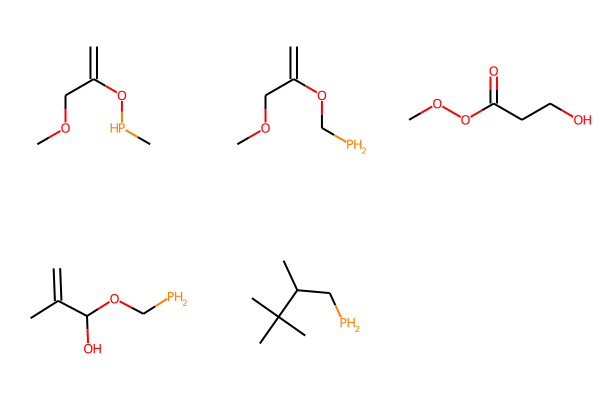

In [13]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)

We can double check that we get the desired property specification for the molecules designed:

In [14]:
X_hits = mcw.transform(smiles_hits)
Y_hits_pred = regr.predict(X_hits)
print(Y_hits_pred)

[109.6602524  109.69774081 110.14718249 110.34096386 110.6941762 ]


Since MACAW embeddings are smooth, we can also use a gradient-based method to navigate the embedding space and retrieve promising molecules. To this end, we use the function `hit_finder_grad`. If we do not provide the arguments `X` (the MACAW embedding of the molecules) or `Y` (property values for the molecules), we may want to increase the parameter `k1` (number of seed molecules to be used in the search).

In [15]:
idx, Y_hits_pred = hit_finder_grad(X_lib, regr, spec, X=X, n_hits=5, k1=100, k2=5)
smiles_hits = [smiles_lib[i] for i in idx]
print(smiles_hits)
print(Y_hits_pred)

['C=CC(C)C(C)(C)C', 'C=CC(C)(C)C(C)C(=C)C', 'CCC(C)C(C)(C)P', 'C=C(C)C(C)(C)C', 'C=C(C)COC(=O)CC']
[109.71719775 109.73815774 109.78238674 110.08920873 110.15267007]


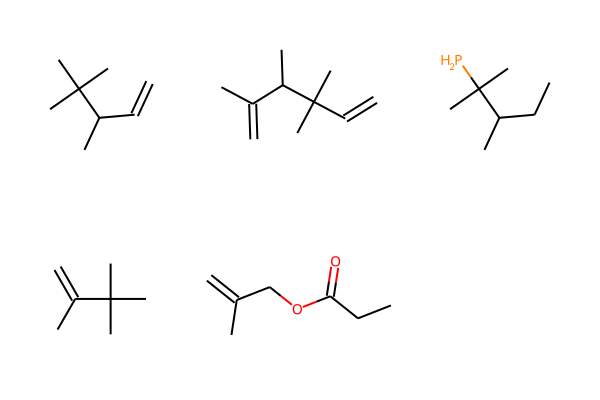

In [16]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)

## Approach 2. Molecular design by evolving focused molecular libraries

Let us use MACAW's library evolver to generate molecules with a predicted RON specification of 120. 

By default, `library_evolver` will evolve 8 generations of molecules. This number can be controlled using the optional argument `n_rounds`. With the optional argument `n_hits` we specify the number of molecules that we want the algorithm to return in its output.

In [32]:
%%capture
spec = 120
smiles_hits, Y_hits_pred = library_evolver(smiles, regr, mcw, spec=spec, n_hits=5, n_rounds=8)

In [33]:
print(smiles_hits)
print(Y_hits_pred)

['CC(C)C(C)C(C)(C)C', 'C=COC(C)=O', 'CC(=O)OC', 'COC(C)=O', 'CC1=CC=CC=C1C']
[115.80532532 116.03720097 118.3693684  118.3693684  119.51670277]


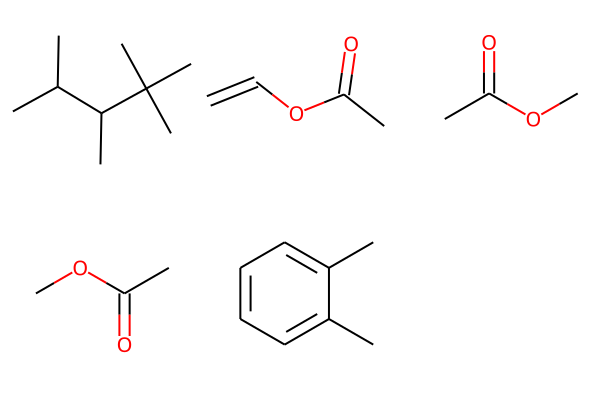

In [34]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)

Since we are working with a RVR model, we can also estimate the prediction errors:

In [35]:
X = mcw.transform(smiles_hits)
Y_hits_pred, Y_hits_pred_std = regr.predict(X, return_std=True)

In [36]:
print(smiles_hits)
print(Y_hits_pred)
print(Y_hits_pred_std)

['CC(C)C(C)C(C)(C)C', 'C=COC(C)=O', 'CC(=O)OC', 'COC(C)=O', 'CC1=CC=CC=C1C']
[115.80532532 116.03720097 118.3693684  118.3693684  119.51670277]
[3.91928036 3.80202883 4.12764964 4.12764964 4.3686951 ]


### Multi-objective optimization in molecular recommendation

We can also design molecules aiming to meet several specifications simultaneously. 

In the next example, we will encourage the recommendation of molecules whose property value is predicted with higher confidence and that have a better Synthetic Accessibility (SA) score. The SA score takes values greater than one, with smaller values indicating better synthetic accessibility. 

We define a custome objective function `f`, which returns a weighted sum of 1) the difference from the desired specification (in this case RON = 40, 80, 120), 2) the prediction uncertainty, and 3) the SA score. Then we ask the `library_evolver` to try to make it zero, which will minimize the objective function.

In [37]:
def SAscore_calc(smi):
    return [sascorer.calculateScore(Chem.MolFromSmiles(s)) for s in smi]

def F(smi, mcw, setpoint):
    X = mcw.transform(smi)
    Y_pred, Y_pred_std = regr.predict(X, return_std=True)
        
    SAScores = SAscore_calc(smi)
    SAScores = np.array(SAScores)
    
    FO = np.abs(Y_pred - setpoint) + 1.*(Y_pred_std) + 2.*SAScores
    return FO


In [38]:
spec = 120

In [39]:
f = lambda smi: F(smi, mcw, setpoint=spec)

Note that since the function `f` directly featurizes the SMILES molecules itself using `mcw`, we do not need the featurizer when calling `library_evolver` (`mcw=None`):

In [40]:
%%capture
smiles_hits, Y_hits_pred = library_evolver(
    smiles, 
    f, 
    mcw=None, 
    spec=0., 
    n_hits=15, 
    n_rounds=8
)

In [41]:
X = mcw.transform(smiles_hits)
Y_hits_pred, Y_hits_pred_std = regr.predict(X, return_std=True)

In [42]:
print(smiles_hits)
print(Y_hits_pred)
print(Y_hits_pred_std)
print(SAscore_calc(smiles_hits))

['CC1=CC=CC=C1C', 'CC(=O)OC', 'COC(C)=O', 'C1CCCCCCNCCCCCC1', 'CCOC(=O)C', 'CCOC(C)=O', 'CCOC(=O)CC', 'CCOC(=O)C=O', 'CCCC(=O)OC', 'CC(C)C(C)C(C)(C)C', 'CC(=O)OCO', 'CC(=O)O', 'CCCC(=O)OC=O', 'NCCC(=O)OC=O', 'CC(=O)OC=O']
[119.51670277 118.3693684  118.3693684  116.899806   115.49533374
 115.49533374 114.13782669 114.90273064 112.93681188 115.80532532
 114.75971526 112.06153864 114.54930431 115.21916843 115.17696364]
[4.3686951  4.12764964 4.12764964 4.44223716 3.93240352 3.93240352
 3.50960536 3.53323624 3.47074771 3.91928036 3.93556938 3.57758037
 3.85801838 3.88747651 3.78728942]
[1.0337432953498862, 1.7363164941764762, 1.7363164941764762, 1.9056521907479862, 1.7562997790553911, 1.7562997790553911, 1.7042005096010016, 2.380915894216386, 1.6392543557548471, 2.90390690232074, 2.4985459329015445, 1.5149307387756714, 2.672385253391843, 3.015216022622612, 3.050536702132315]


The point estimates for the RON of these molecules are not as close to the desired specification as in the design example above, but the prediction errors are smaller and the SA scores are low (close to 1).

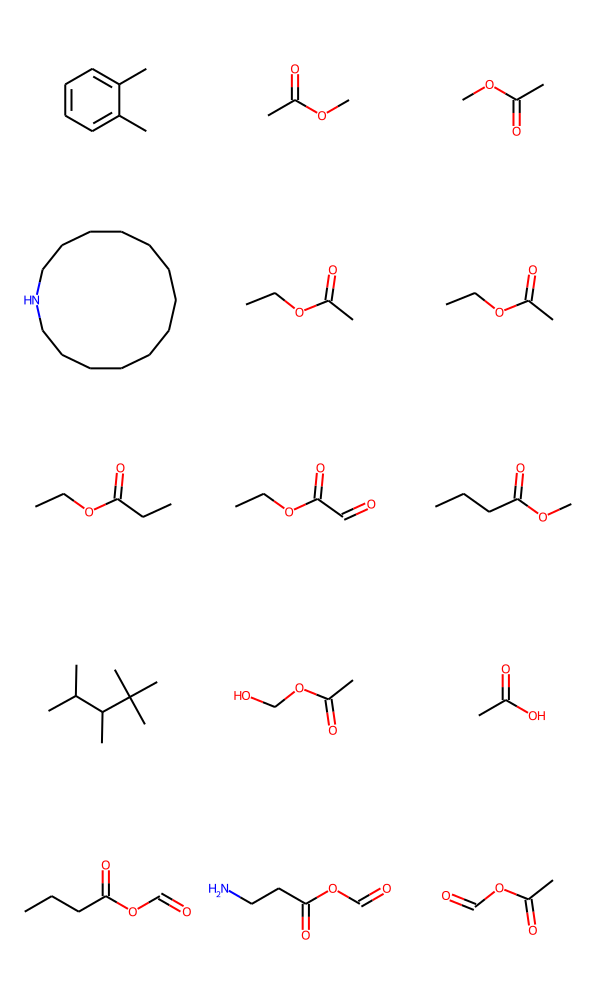

In [43]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)

Let us now try to design molecules with a RON design specification of 80:

In [44]:
spec = 80
f = lambda smi: F(smi, mcw, setpoint=spec)

In [45]:
%%capture
smiles_hits, Y_hits_pred = library_evolver(
    smiles, 
    f, 
    mcw=None, 
    spec=0., 
    n_hits=15, 
    n_rounds=8
)

In [46]:
X = mcw.transform(smiles_hits)
Y_hits_pred, Y_hits_pred_std = regr.predict(X, return_std=True)

In [47]:
print(smiles_hits)
print(Y_hits_pred)
print(Y_hits_pred_std)
print(SAscore_calc(smiles_hits))

['CCCCCC(C)=O', 'COCCCCCCCC(C)(C)CCCCCOC', 'CC(C)C1CCCC1', 'CCCNCCC(C)=O', 'CCCCCCOCCC(C)=O', 'CCCCCCCCCCCOCCCCOOCCCC', 'C=COCCCCCCCCCCCCOCCNCCCCCCC', 'CCOCCNCCCCCC=CCCCCCCCCCCCO', 'CCCCCCCCC(C)(C)CCCC', 'CCCCCCCCCC(C)(C)CC', 'CCCCCCNCCCCCCCCCCCCCCCCCCOCCO', 'CCCCCCCCC(C)(C)CC', 'C=C(C)N(C)CCCCCCCCCCOC', 'CCCCCCCCC(C)(C)CCC', 'CCCCCC(C)(C)CCCC']
[79.45809235 80.20870038 80.90784416 79.57250691 80.67912342 79.52638991
 80.08202726 80.23759534 80.56071208 80.56071208 79.3112282  80.56071208
 80.29884924 80.56071208 80.56071208]
[3.50628522 3.47115958 3.35388465 3.49507998 3.49835705 3.40729484
 3.36418814 3.297586   3.71482301 3.71482301 3.41749572 3.71482301
 3.48921963 3.71482301 3.71482301]
[1.6529918467984377, 2.124963799045675, 1.8341579806645694, 2.0512356995332492, 1.9242660369323126, 2.1149448468668073, 2.3698438619332958, 2.341330055986969, 2.0067402482598276, 2.008963986501854, 2.1007725197877587, 2.0195206291297065, 2.265723537650704, 2.0357927314411253, 2.0406506960232225]


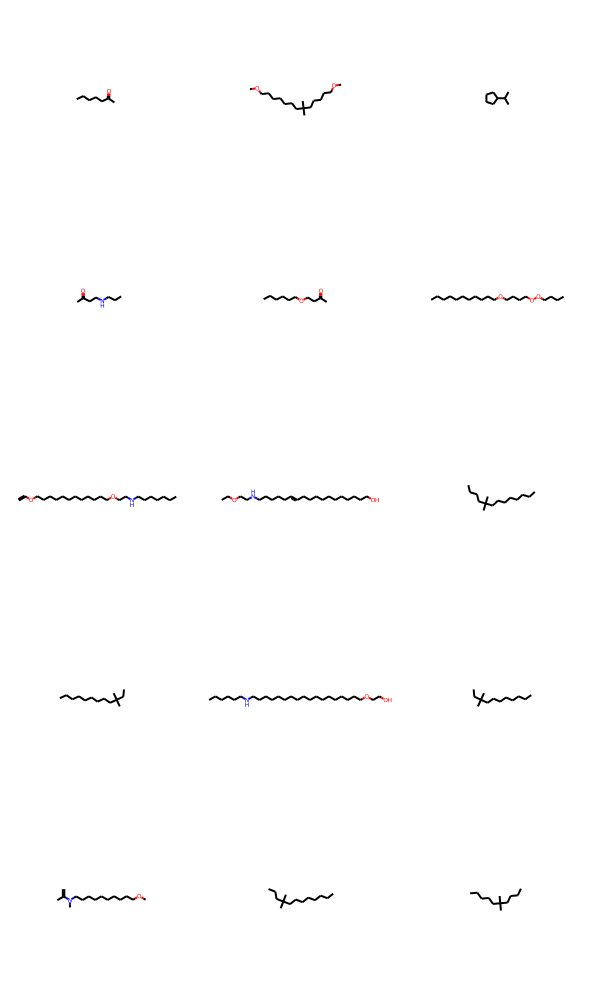

In [48]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)

Let us now try to design molecules with a RON design specification of 40:

In [49]:
spec = 40
f = lambda smi: F(smi, mcw, setpoint=spec)

In [50]:
%%capture
smiles_hits, Y_hits_pred = library_evolver(
    smiles, 
    f, 
    mcw=None, 
    spec=0., 
    n_hits=15, 
    n_rounds=8
)

In [51]:
X = mcw.transform(smiles_hits)
Y_hits_pred, Y_hits_pred_std = regr.predict(X, return_std=True)

In [52]:
print(smiles_hits)
print(Y_hits_pred)
print(Y_hits_pred_std)
print(SAscore_calc(smiles_hits))

['C1CCCCCC1', 'CCCCCCCCCCCCCCCCCCCCCCOP', 'CCCCCCCCCCCCCCCCCCCCCCCO', 'CCCCCCCCCCCCCCCCCCCCCO', 'CCC(C)CCC1CCCCCC1', 'CCCCCCC(C)CCOCCCCCCC=O', 'CCOCCC(C)CCCCCCCC=O', 'CCCCCC(C)C1CC1', 'CCCC(C)CCCCOCCC=O', 'CCCCCC=COCC(C)CCCCCCCCC', 'CCCOCCCCC(C)CCC=O', 'COCCOCCCC(C)CCC=O', 'CC=CCCCCCCC(C)CCCCCCO', 'COCCC(C)CCCCCCCCCOCCCC=O', 'CCCC(C)CCCCOCCCC=O']
[39.21779861 39.71992898 37.87587836 37.87587836 40.20445621 39.96314923
 39.96314923 40.91560691 39.99254415 40.1615945  40.17723795 40.17591007
 39.72129073 39.64087149 40.35209478]
[4.44652785 3.81443794 3.90976346 3.90976346 4.10660066 3.79155614
 3.79155614 3.66184346 3.82234884 3.68071741 3.80296292 3.76151172
 3.94101556 3.7911819  3.82252718]
[1.0, 2.335994756109219, 1.4785622348488765, 1.4843430407966771, 2.3920347128200774, 2.6968520144438752, 2.7251500078061515, 2.3989416683641043, 2.838950520516823, 2.8620520646913636, 2.8068487453688924, 2.8666818814635686, 2.727212614558331, 2.7815813067361415, 2.778586739173825]


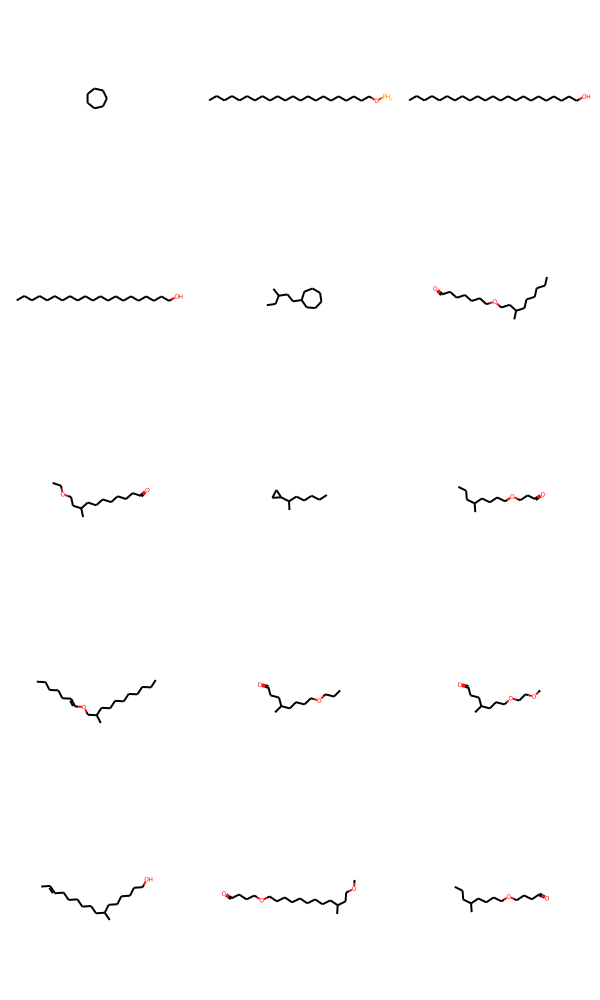

In [53]:
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_hits]

Draw.MolsToGridImage(molecules, subImgSize=(200,200), molsPerRow=3, useSVG=True)